# 1. Introduction

Graphene blocks are comprised of two major data structures, an Invertible Bloom Lookup Table (IBLT) labeled $I$ and a Bloom filter (BF) labeled $B$.
In this document we analyze two size tuning procedures for Graphene blocks. Although the [original Graphene paper](https://people.cs.umass.edu/~gbiss/graphene.pdf) offered an optimization formula, the current version (as of commit 786c1d1) uses brute-force search to find optimal sizes for $I$ and $B$. This decision was made because the optimization formula is unable to account for discontinuous functions such as floors and ceilings. As a result, the formula is inaccurate, particularly for Graphene blocks containing relatively few transactions. Nevertheless, for large blocks, the formula should work quite well, and is much more efficient than brute-force search. Therefore, one of the goals of this document is to determine how large a block must be in order for the optimization formula to work well.

The second goal of this document is to determine a suitable increase in the size of $I$ that can compensate for the natural variance in the false positive rate (FPR) of $B$. It is relatively easy to determine the expected number of false positives (FPs) for a BF of given size and holding a given number of items. However, some fraction of the time, more FPs will be generated than expected. In such cases we want $I$ to be large enough to decode.

# 2. Optimization formula

There are two sources of error that must be accounted for when sizing $I$ and $B$: 

1. Transactions $M$ that are in the block but missing from the receiver mempool. 
2. Transactions $S$ that are not the block but are in the receiver mempool and which pass through the $B$ as FPs. 

$I$ must be sized large enough so that all transactions in $M \cup S$ can be recovered. Define $E$ to be the set of *excess transactions* that are in the receiver mempool, but not in the block. If $f_B$ is the FPR for $B$, then in expectation, $f_B |E| = |S|$. It is not possible for the sender to control $M$, but the size of $S$ is completely in his control. By reducing the FPR of $B$, the sender can make $S$ arbitrarily small, reducing the required size of $I$. However reducing the FPR of $B$ also requires an increase in the size of $B$. 

Thus, optimizing Graphene block size can be accomplished by determining the ideal choice for $s = |S|$, which leads to a minimal combined size for $I$ and $B$. Working with the actual sizes for $I$ and $B$, that arise from their c++ implementations, along with a simplified definition of FPR $f_B$ that ignores floors and ceilings, we can develop an expression for total size $T$. We begin with a table of variables.

| variable | description |
|:--------:|-------------|
| $k$ | number of hash functions in $I$ |
| $b$ | BF cell size (bytes)|
| $n$ | items in block |
| $i$ | IBLT cell size (bytes) |
| $v$ | IBLT overhead |
| $M$ | Missing transactions as defined above |
| $S$ | False positives as defined above |
| $E$ | Excess transactions in mempool |
| $s$ | size of $S$, $|S|$
| $f_B(s)$ | implied FPR of $B$ given $s$ | 
| $I(s)$ | Size of $I$ given $s$ |
| $B(s)$ | Size $B$ given $s$ |
| $T(s)$ | Aggregate size of $I$ and $B$ given s| 

Based on the definitions above, we have the following exact sizes based on the current C++ implementation of Graphene.

$$f_B(s, |E|) = \frac{s}{|E|}$$
$$B'(s, |E|, n) = \left \lfloor \frac{b n}{8} \left( \frac{-1}{\ln^2(2)} \right) \right \rfloor \ln(f_B(s, |E|))$$
$$I'(s, k, n) = i k \lceil \lceil v s \rceil / k \rceil$$
$$T'(s, |E|, k, n) =  I'(s, k) + B'(s, |E|, n)$$

And after removing floor and ceiling functions, we the following continuous approximations.

$$f_B(s, |E|) = \frac{s}{|E|}$$
$$B(s, |E|, n) = \frac{b n}{8} \left( \frac{-1}{\ln^2(2)} \right) \ln(f_B(s, |E|))$$
$$I(s) = i v s$$
$$T(s, |E|, n) =  I(s) + B(s, |E|, n)$$

Taking the derivative of $T(s)$ with respect to $s$ and setting the result equal to zero, we can solve for the optimal value of $s$ assuming a continuous size model:

$$s^* = \frac{bn}{8iv \ln^2(2)}.$$

In the code below, we analyze the accuracy of the continuous model, relative to the exact solution, for various block sizes $n$ where the number of excess transaction in the mempool $e$ varies as a function of $n$.

In [3]:
# setup
import numpy as np
import pylab as plt
import sys

# Actual values in c++ implementation
b = 1; i = 17; v = 1.5

def f_B(s, e): return 1.0 if s > e or e == 0 else s / e
def Bp(s, e, n): return np.floor(b * n / 8.0 * (-1 / np.log(2)**2) * np.log(f_B(s, e)))
def B(s, e, n): return b * n / 8.0 * (-1 / np.log(2)**2) * np.log(f_B(s, e))
def Ip(s, k): return i * k * np.ceil(np.ceil(v * s) / k)
def I(s): return i * v * s
def Tp(s, e, k, n): return Ip(s, k) + Bp(s, e, n)
def T(s, e, n): return I(s, k) + B(s, e, n)
def s_opt(n): return b * n / (8 * i * v * np.log(2)**2)   

def brute_best(n, e, k):
    best_s = None
    best_T = sys.maxsize
    for s in range(1, n+1):
        t = Tp(s, e, k, n)
        if t < best_T:
            best_T = t
            best_s = s
            
    return best_s

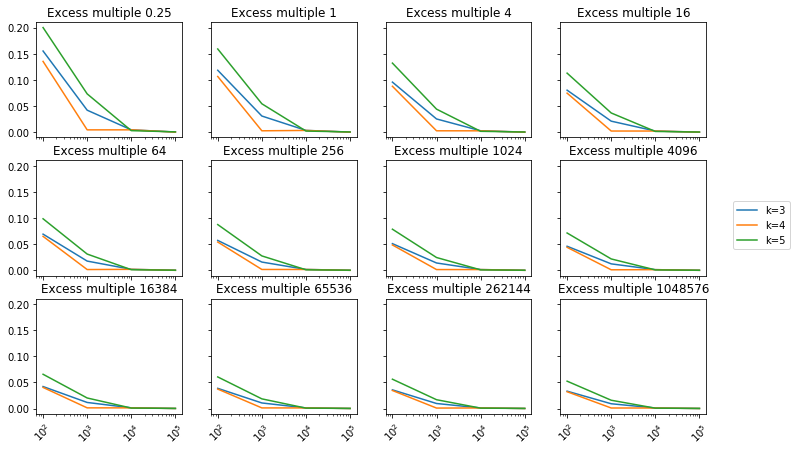

In [32]:
# vary e with n
k = 5
rows, cols = 3, 4
f, axes = plt.subplots(rows, cols, sharey=True, sharex=True, figsize=(rows*4,cols*1.8))
ns = [100, 1000, 10000, 100000]
mults = [2**(i-2) for i in range(0, 24, 2)]
for idx in range(len(mults)):
    lines = []
    for k in [3,4,5]:
        mult = mults[idx]
        T_discs = {n: Tp(brute_best(n, n*mult, k), n*mult, k, n) for n in ns}
        T_conts = {n: Tp(s_opt(n), n*mult, k, n) for n in ns}
        diffs = [min(1, (T_conts[n] - T_discs[n])/ T_discs[n]) for n in ns]
        row = idx // cols
        col = idx % cols
        line, = axes[row, col].semilogx(ns, diffs)
        lines.append(line)
        axes[row, col].set_title('Excess multiple ' + repr(mult))
        plt.setp(axes[row, col].get_xticklabels(), rotation=45)
legend = f.legend(lines, ('k=3', 'k=4', 'k=5', 'k=6', 'k=7'), 'center right')

## 2.1 Analysis of Optimization Formula

In the previous section, we showed that $s^*$ is the best choice for $s$ assuming a continuous model of data structure sizes. Let $s'$ denote the overall best choice for $s$, using actual sizes. From the plots above, we can see that the relative error in size between actual $T'(s',\ldots)$ and the continuous approximation $T(s^*,\ldots)$ generally decreases with both $n$ and $e$. On the other hand, error varies non-monotonically with the number of hash functions $k$. The number of hash functions used by Graphene depends on the number of transactions in the block, and is set by the [`paramMap`](https://github.com/BitcoinUnlimited/BitcoinUnlimited/blob/92151fb2ad7489c1229b5d05e80c5a4dc5cef53d/src/iblt_params.h#L44) lookup table. From the code, we can see that $k=4$ hash functions is used for all blocks with 64 or more transactions. And from the plot above, it is evident that for $k=4$, the error between $T'(s',\ldots)$ and $T'(s^*,\ldots)$ is bounded by 10% as long as $n > 200$ and $e > n / 4$. Therefore, the continuous solution $s'$ is a reasonable choice for those values of $n$ and $e$.